In [ ]:

#| default_exp current


In [ ]:
#| hide
from nbdev.showdoc import *
import pandas as pd

In [ ]:
#| export
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Current Correction

> Adjust speed through water for strength of current

This module represents the Appendix H of the ITTC, and provides the functionality to correct for current.

The current correction approaches can only really be used if the ITTC speed power process has been followed closely. The corrections require that there are multiple runs for several speed settings. This allows a regression to be made. If there is only one speed setting then the methods described in appendix H will not be applicable. 
If multiple double runs or runs at different speeds have not been performed then ship current sensors, met-ocean data, or other methods will have to be used.

## Which to choose?

Although the two methods are not mutually exlusive, they do have different minimum data gathering requirements in order to be used. 

- The iterative method can be used when the seatrial has performed a **SINGLE** set of double runs at **DIFFERENT** power settings
- The Mean of Means method can be performed when there have been **TWO** sets of double-runs at the **SAME** power setting

## Iterative Method

The iterative method assumes a current that varies with a semidurational period. This period is typically 12 hours, 25 minutes and 12 seconds, which can also be described as 0.51753 of a day. The function can use any speed unit and any unit of power although, the original ITTC documentation uses Knots and kWh respectively. 

The process for estimating the current and the true speed through water is described below.


### Step 1: Estimate the speed-power curve

Using the known speed over ground ($V_g$) values and observed power ($P_{obs}(V_s)$) values for each power/speed setting, find the coefficients of the equation

$$P(V_s) =a+ bV_s^q$$

Where:

- P(V_s) = the engine power at speed V_s
- a,b, q = unknown coefficients

### Step 2: Estimate speed through water from observed power and speed-power model

using the coefficients of the speed power mode and the observed power calculate and estimate of the necessary speed through water using 

$$V_s = \sqrt[q]{\frac{P(V_s)-a}{b}}$$

### Step 3: Estimate Current and current coefficients

Using $V_c = V_G - V_s$, get an estimate of $V_c$ for each speed setting and use it to find the coefficients of the following equation using leasts-squares

$$V_c = V_{C,C}\textrm{cos}(\frac{2\pi}{T_c}t) + V_{C,S}\textrm{sin}(\frac{2\pi}{T_c}t) + V_{C,T}t + V_{C,0}$$

Where:

- V_c = the current speed in knots
- T_c = is the period of variation of current speed, it is measured in hours
- t = the time for each run relative to the first run, it is measured in hours.
- $V_{C,C}, V_{C,S}, V_{C,T}, V_{C,0} =$ are unknown factors which found through iteration

Once the coefficients have been calculated the value of $V_c$ can be updated

### Step 4: Re-calculate the speed-power curve coefficients

Using the updated value of $V_c$ update the value of $V_s$ and re-calculate the parameters a.b and q for the speed power curve.

Using the new speed power curve and the estimated values of $V_s$ create the predicted values of engine power.

### Step 5: Measure the error between the observed and predicted Enginer power

Using the equation

$$MSE =\sum (P_{pred}(V_s)-P_{obs}(V_s))^2$$

measure the error of the estimates. if the error is larger than tolerance go to Step 2, otherwise if the process has converged and the error minimised, finish and return the final values of $V_c$ and $V_s$

When setting the tolerance any small value is acceptable. typically a tolerance of $10^{-6}$ is used however values as large as $10^{-2}$ would probably have negligable impact on the final analysis


### Diagram

The below diagram provides a schematic of the process described above

```{mermaid}
graph LR;
  A(SOG) --> B(Step 1)
  Z(Power) -->B
  B --> C(Step 2)
  C --> D(Step 3)
  D --> E(Step 4)
  E --> L{Convergence?}
  L -- No --> C
  L -- Yes --> M[Return STW]
```

**ITTC equations:** H-1 to H-5 

In [ ]:
#| export

def estimate_speed_through_water(P_id, V_g, t, T_c, tolerance=1e-6, max_iter=1000):

    def current_speed(t, V_c_C, V_c_S, V_c_T, V_c_0, T_c):
        return V_c_C * np.cos((2 * np.pi / T_c) * t) + V_c_S * np.sin((2 * np.pi / T_c) * t) + V_c_T * t + V_c_0

    def power_eq(V_s, a, b, q):
        return a + b * V_s**q
    #get initial estimates for the power law curve parameters
    popt, _ = curve_fit(power_eq, V_g, P_id, p0=[1, 1, 1])
    a, b, q = popt
    
    for i in range(max_iter):
        # Calculate stw
        V_s = np.power((P_id - a) / b, 1/q)
        
        # Calculate current
        V_c = V_g - V_s
        
        # FCalucalte current coefs using curve fitting
        popt, _ = curve_fit(lambda t, V_c_C, V_c_S, V_c_T, V_c_0: current_speed(t, V_c_C, V_c_S, V_c_T, V_c_0, T_c), t, V_c, p0=[1, 1, 1, 1])
        
        # Update V_c_C, V_c_S, V_c_T, V_c_0 using the fitted parameters
        V_c_C, V_c_S, V_c_T, V_c_0 = popt
        
        # Calculate the new current using fitted params
        V_c_new = current_speed(t, V_c_C, V_c_S, V_c_T, V_c_0, T_c)
        
        # Update update stw
        V_s = V_g - V_c_new
        
        # Update the power law parameters a, b, and q using curve fitting and new stw estimate
        popt, _ = curve_fit(power_eq, V_s, P_id, p0=[a, b, q])
        a, b, q = popt
        
        #calculates estimated power using new power law curve
        P_obs = a + b * V_s ** q
        #compare error
        power_error = sum((P_obs - P_id) ** 2)
        
        # Check convergence
        if power_error < tolerance:
            break
    
    return V_s



In [ ]:
T_c = 12
V_c_C=-0.1
V_c_S=-0.5
V_c_T=0.2
V_c_0=0.1
t = np.array([0, 1, 2, 3, 4])  # Time values relative to the first run
V_g = np.array([5, 10, 15, 20, 25])
V_c_true = V_c_C * np.cos((2 * np.pi / T_c) * t) + V_c_S * np.sin((2 * np.pi / T_c) * t) + V_c_T * t + V_c_0
#current_speed(t=t, V_c_C=-0.1, V_c_S=-0.5, V_c_T=0.2, V_c_0=0.1, T_c=T_c)
V_s_true = V_c_true + V_g
a_true = 2
b_true = 3
c_true = 3
P_id = a_true + b_true * V_s_true ** c_true

V_s = estimate_speed_through_water(P_id, V_g, t, T_c)
print("Estimated speed through water:", V_s)


Estimated speed through water: [ 5.20805809 10.06554111 14.96931249 19.95185998 25.02456333]


## Mean of means method

Another approach to finding the current


$$V_s = \frac{V_{G1} + 3V_{G2}+ 3V_{G3} + V_{G4}}{8}$$

Where $V_s$ is the speed through water and  $V_{G1}$ to $V_{G4}$ are the mean speed over-ground for each double run at a given speed.

The current is assumed to have a parabolic form and as such can be expressed as 

$$V_c = V_{C,2} t^2 + V_{C,1} t +V_{C,1}$$

Where $V_c$ is the current speed, and $V_{C,2}$, $V_{C,1}$, $V_{C,0}$ are unknown factors.

The solution to the current equation can therefore be found by treating it as a system of linear equations of the form $y = X\beta$. The system of linear equations is shown below.

$$\begin{bmatrix}
    V_{G1} - V_s  \\
    V_{G2} - V_s  \\
    V_{G3} - V_s \\
    V_{G4} - V_s  \\
\end{bmatrix}
= 
\begin{bmatrix}
    (t + 3\Delta t)^2 & -(t + 3\Delta t) & 1 \\
    (t + \Delta t)^2 & -(t + \Delta t) & 1 \\
    (t - \Delta t)^2 & -(t - \Delta t) & 1 \\
    (t - 3\Delta t)^2 & -(t - 3\Delta t) & 1 \\
\end{bmatrix}
\cdot
\begin{bmatrix}
    V_{C,2}\\
    V_{C,1} \\
    V_{C,0} \\
\end{bmatrix} $$


This equation demonstrates the need to perform two double runs, i.e. 4 runs as this will result in four equations with the 3 uknowns of $V_{C,2}$, $V_{C,1}$, $V_{C,0}$. It should be noted that as current is not a parabola the values found should be used for interpolation not extrapolation. Setting the example below to 24 hours will produce terrifying torrents, which are obviously not realistic.

In [ ]:
#| export
def current_mean_of_means(list_of_speeds:list, # The mean speed over ground across a double run,
                           start_time:float, # Time in decimal hours when the first run took place,
                           time_between_runs:float #Time in decimal hours between each run. Note the time difference must be consistent between all runs
                          ):

    t = start_time
    delta_t = time_between_runs/2

    V_G1, V_G2, V_G3, V_G4 = list_of_speeds
    Vs = (V_G1 + 3 * V_G2 + 3 * V_G3 + V_G4) / 8

    A = np.array([  [(t + 3*delta_t)**2, -(t + 3*delta_t), 1],
                    [(t + 1*delta_t)**2, -(t + 1*delta_t), 1],
                    [(t - 1*delta_t)**2, -(t - 1*delta_t), 1],
                    [(t - 3*delta_t)**2, -(t - 3*delta_t), 1]])

    b = np.array([V_G1 - Vs, V_G2 - Vs, V_G3 - Vs, V_G4 - Vs])

    x, residuals, rank, singular_values = np.linalg.lstsq(A, b, rcond=None)


    return x, residuals


In [ ]:
list_of_speeds = [2.5, 2.6, 2.6, 2.5]  # Mean speed over ground across a double run
start_time = 0.0  # Time in decimal hours when the first run took place
time_between_runs = 0.75  # Time in decimal hours between each run

result, residuals = current_mean_of_means(list_of_speeds, start_time, time_between_runs)
print("Result:", result)

Result: [-8.88888889e-02  6.93889390e-18  3.75000000e-02]


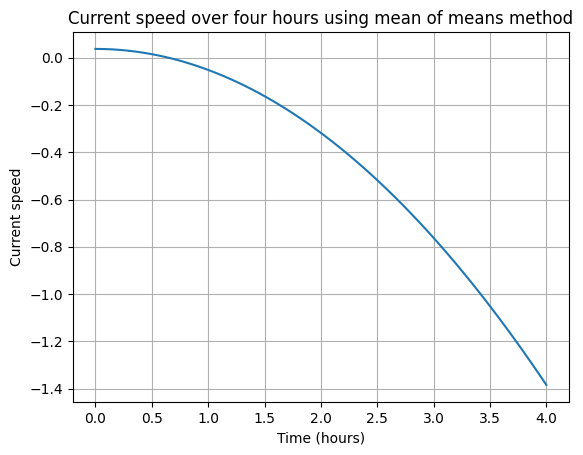

In [ ]:
def quadratic_function(t, coeffs):
    a, b, c = coeffs
    return a * t**2 + b * t + c

# Calculate the current speed throughout the day
times = np.linspace(0, 4, 100)  
current_strength = quadratic_function(times, result) 

# Plot the current speed over the 24-hour period
plt.plot(times, current_strength)
plt.xlabel('Time (hours)')
plt.ylabel('Current speed')
plt.title('Current speed over four hours using mean of means method')
plt.grid(True)
plt.show()

In [ ]:
import nbdev; nbdev.nbdev_export()